<a href="https://colab.research.google.com/github/Noora66612/bert-imdb-sentiment-analysis/blob/main/bert_imdb_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project: BERT IMDB Sentiment Analysis**

### **1. Project Overview**
This project implements a binary sentiment classification system designed to analyze unstructured user feedback (movie reviews) and determine the underlying emotional tone (**Positive** vs. **Negative**). By leveraging **Transfer Learning**, the system fine-tunes a pre-trained **BERT (Bidirectional Encoder Representations from Transformers)** model to achieve state-of-the-art accuracy on the IMDB dataset.

### **2. Business & Technical Context**
* **Goal:** To automate the extraction of customer sentiment from large-scale text data, enabling scalable product analytics and user experience research.
* **Data Source:** The **IMDB Large Movie Review Dataset**, consisting of 50,000 highly polar reviews (Maas et al., 2011).
* **Methodology:**
    * **Data Preprocessing:** Implemented a robust pipeline utilizing dynamic tokenization, padding/truncation strategies (max length 512), and custom PyTorch `Dataset` loaders to handle variable-length sequences.
    * **Model Architecture:** Utilized `bert-base-uncased` as the backbone encoder. Engineered a downstream classifier by appending a **Dropout layer (p=0.1)** for regularization and a **Linear layer** to map 768-dimensional contextual embeddings to binary logits.
    * **Training Strategy:** Employed the **Adam optimizer** with a precise learning rate (`2e-5`) to fine-tune model parameters, preventing catastrophic forgetting while optimizing Cross-Entropy Loss.

### **3. Key Results**
* Achieved **~95% Accuracy** on the test set after fine-tuning for 3-4 epochs.
* Demonstrated robust generalization by monitoring **F1-score**, **Precision**, and **Recall** to ensure balanced performance across classes.
* Deployed an inference function capable of predicting sentiment probabilities for unseen, real-world text inputs.

### **4. Tech Stack**
* **Deep Learning Framework:** PyTorch
* **NLP Library:** Hugging Face Transformers (`BertTokenizer`, `BertModel`)
* **Data Manipulation:** Pandas, Scikit-learn (Train/Test splits, Metrics)
* **Visualization:** Matplotlib (Learning curves)

---

### **5. References & Acknowledgements**
This project builds upon the following academic resources and open-source frameworks:
* **Dataset:** Maas, A. L., Daly, R. E., Pham, P. T., Huang, D., Ng, A. Y., & Potts, C. (2011). [Learning Word Vectors for Sentiment Analysis](https://aclanthology.org/P11-1015.pdf). In *Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics*.
* **Framework:** Implementation leverages the pre-trained models provided by [Hugging Face](https://huggingface.co/).

## **1. Environment Setup & Dependencies**
Installing the Hugging Face `datasets` and `transformers` libraries, and importing necessary modules for PyTorch and Scikit-learn.

In [ ]:
!pip install datasets transformers

In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertModel
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as Fun
import transformers
import matplotlib.pyplot as plt
import pandas as pd
import time
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

## **2. Utility Functions: Metrics & Checkpointing**
Defining helper functions for:
* **Evaluation:** Calculating Accuracy, F1-score, Precision, and Recall.
* **Model Management:** Saving and loading model weights (Checkpoints) to ensure reproducibility.

In [ ]:
# 1. Prediction & Evaluation Helpers
def get_pred(logits):
    """
    Decodes model output logits into predicted class labels.
    Performs an argmax operation along the last dimension to select the class with the highest score.
    """
    return torch.argmax(logits, dim=1)

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# calculate confusion metrics
def cal_metrics(pred, ans):
    """
    Computes classification metrics including Accuracy, F1-score, Recall, and Precision.

    Args:
        pred (torch.Tensor): Predicted labels from the model.
        ans (torch.Tensor): Ground truth labels.

    Returns:
        tuple: (accuracy, f1, recall, precision)
    """
    # Detach tensors, move to CPU, and convert to NumPy arrays for Scikit-learn compatibility
    pred = pred.cpu().numpy()
    ans = ans.cpu().numpy()

    acc = accuracy_score(ans, pred)
    f1 = f1_score(ans, pred)
    recall = recall_score(ans, pred)
    precision = precision_score(ans, pred)

    return acc, f1, recall, precision

In [ ]:
# 2. Model Persistence Helpers
def save_checkpoint(save_path, model):
  """Saves the model state dictionary to the specified path."""
  if save_path == None:
      return
  torch.save(model.state_dict(), save_path)
  print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model, device):
  """Loads model weights from a checkpoint file."""
  if load_path==None:
      return

  state_dict = torch.load(load_path, map_location=device)
  print(f'Model loaded from <== {load_path}')

  model.load_state_dict(state_dict)
  return model

### **3. Data Ingestion & Exploratory Analysis**
Downloading the IMDB dataset from Hugging Face Hub and inspecting the data structure to ensure integrity.

In [ ]:
from datasets import load_dataset

# 1. Load the raw dataset
dataset = load_dataset("imdb")

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
# 2. Inspect data structure
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
dataset['train'][0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

### **4. Data Consolidation & Stratified Split**
To ensure a rigorous evaluation pipeline, we consolidate the original splits and perform a custom **Stratified Shuffle-Split**.

**Strategy:**
* **Merge:** Combine original Train and Test sets into a single corpus.
* **Re-split:** Partition into **Train (80%)**, **Validation (10%)**, and **Test (10%)** sets.
* **Stratification:** Ensures the positive/negative sentiment ratio remains balanced across all subsets.

In [ ]:
# 1. Convert Hugging Face datasets to Pandas DataFrames
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

# 2. Merge into a single dataframe
all_df = pd.concat([train_df, test_df], ignore_index=True)

# 3. Stratified Split Strategy (8:1:1)
# First split: 80% Train, 20% Temp (Val + Test)
train_df, test_df = train_test_split(all_df, test_size=0.2, random_state=42, stratify=all_df['label'])
print(train_df.head())

                                                    text  label
48903  Having a close experience with one such patien...      1
10174  This is by far one of the worst movies i have ...      0
34019  This film is a great disappointment. Director ...      0
9815   When I first popped in Happy Birthday to Me, I...      0
6895   I signed in just to comment on how awfully stu...      0


In [ ]:
# Verifying the balance of the consolidated dataset to ensure no class imbalance issues exist (ideally 50/50).
all_df.label.value_counts() / len(all_df)

,count
label,
0,0.5
1,0.5


### **5. Final Partitioning & Persistence**
Executing the final split to create **Train (80%)**, **Validation (10%)**, and **Test (10%)** sets. The processed datasets are then saved as TSV files for reproducibility.

In [ ]:
train_df, temp_data = train_test_split(all_df, random_state=1111, train_size=0.8)
dev_df, test_df = train_test_split(temp_data, random_state=1111, train_size=0.5)
print('# of train_df:', len(train_df))
print('# of dev_df:', len(dev_df))
print('# of test_df data:', len(test_df))

# save data
train_df.to_csv('./train.tsv', sep='\t', index=False)
dev_df.to_csv('./val.tsv', sep='\t', index=False)
test_df.to_csv('./test.tsv', sep='\t', index=False)

# of train_df: 40000
# of dev_df: 5000
# of test_df data: 5000


### **6. Custom Dataset & Tokenization Pipeline**
Implementing a custom PyTorch `Dataset` class to manage data ingestion. This class integrates the **BERT tokenizer** to transform raw text into model-compatible tensors (Input IDs, Attention Masks) on-the-fly, ensuring efficient memory usage.

**Key Features:**
* **Dynamic Tokenization:** Handles padding and truncation to a fixed `max_length`.
* **Label Encoding:** Supports both binary and one-hot encoding for scalability.
* **Mode Handling:** Differentiates between `train/val` (with labels) and `test` (inference mode) splits.

In [ ]:
# Custom Dataset class for handling BERT input formatting
class CustomDataset(Dataset):
  def __init__(self, mode, df, specify, args):
    # Ensure valid partition: train, val, or test
    assert mode in ["train", "val", "test"]
    self.mode = mode
    self.df = df
    self.specify = specify # Column containing the text data to be analyzed
    if self.mode != 'test':
      self.label = df['label']
    self.tokenizer = AutoTokenizer.from_pretrained(args["config"])
    self.max_len = args["max_len"]
    self.num_class = args["num_class"]

  def __len__(self):
    return len(self.df)

  # Encodes labels into one-hot vectors (required for multi-class tasks)
  def one_hot_label(self, label):
    return Fun.one_hot(torch.tensor(label), num_classes = self.num_class)

  # Tokenizes raw text using the pre-trained BERT tokenizer
  def tokenize(self, input_text):
    tokens = self.tokenizer(
      input_text,
      padding='max_length',
      truncation=True,
      max_length=self.max_len,
      return_tensors='pt'  # Return PyTorch tensors
  )
    # Remove the batch dimension added by return_tensors='pt'
    input_ids = tokens['input_ids'].squeeze(0)
    attention_mask = tokens['attention_mask'].squeeze(0)
    # Handle token_type_ids for models that require them
    token_type_ids = tokens['token_type_ids'].squeeze(0) if 'token_type_ids' in tokens else torch.zeros_like(input_ids)

    return input_ids, attention_mask, token_type_ids

  # Retrieves and processes a single data sample
  def __getitem__(self, index):

    sentence = str(self.df[self.specify][index])
    ids, mask, token_type_ids = self.tokenize(sentence)


    if self.mode == "test":
        return torch.tensor(ids, dtype=torch.long), torch.tensor(mask, dtype=torch.long), \
            torch.tensor(token_type_ids, dtype=torch.long)
    else:
        if self.num_class > 2:
          return torch.tensor(ids, dtype=torch.long), torch.tensor(mask, dtype=torch.long), \
            torch.tensor(token_type_ids, dtype=torch.long), self.one_hot_label(self.label[index])
        else:
          return torch.tensor(ids, dtype=torch.long), torch.tensor(mask, dtype=torch.long), \
            torch.tensor(token_type_ids, dtype=torch.long), torch.tensor(self.label[index], dtype=torch.long)

### **7. Model Architecture: BERT for Sequence Classification**
Constructing a custom classifier class inheriting from `BertPreTrainedModel`. This architecture leverages the pre-trained BERT encoder to generate contextual embeddings, which are then passed through a task-specific classification head.

**Architecture Breakdown:**
1.  **Backbone:** `BertModel` (pre-trained) extracts the 768-dimensional contextual representation for the `[CLS]` token.
2.  **Regularization:** A `Dropout` layer (p=0.1) is applied to the pooled output to prevent overfitting during fine-tuning.
3.  **Classifier:** A `Linear` layer maps the hidden states to the target class logits (Dimension: `hidden_size` $\to$ `num_class`).

**Forward Pass Strategy:**
The model takes input indices and attention masks, passes them through the BERT transformer, extracts the pooled output (sentence embedding), and computes the final logits for classification.



In [ ]:
import torch.nn as nn

# Custom BERT Classifier Module
class BertClassifier(BertPreTrainedModel):
  def __init__(self, config, args):
    super(BertClassifier, self).__init__(config)
    self.bert = BertModel(config)

    # Dropout layer for regularization
    self.dropout = nn.Dropout(p=0.1)

    # Classifier Head: Linear layer mapping BERT's hidden size (768) -> num_class (2)
    self.classifier = nn.Linear(config.hidden_size, args["num_class"])

    # Initialize weights (inherited from BertPreTrainedModel)
    self.init_weights()

  def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, position_ids=None,
              head_mask=None, inputs_embeds=None, labels=None, output_attentions=None,
              output_hidden_states=None, return_dict=None):

      # 1. BERT Encoder pass
      # outputs[0]: last_hidden_state (sequence_output)
      # outputs[1]: pooled_output (CLS token embedding, processed by a linear layer + tanh)
      outputs = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids,
          position_ids=position_ids,
          head_mask=head_mask,
          inputs_embeds=inputs_embeds,
          output_attentions=output_attentions,
          output_hidden_states=output_hidden_states,
          return_dict=return_dict
      )

      # 2. Feature Extraction (CLS token representation)
      pooled_output = outputs[1]  # Shape: (batch_size, hidden_size)

      # 3. Classifier Head (Dropout + Linear)
      pooled_output = self.dropout(pooled_output)
      logits = self.classifier(pooled_output)  # Shape: (batch_size, num_class)

      return logits

### **8. Evaluation Protocol**
Defining the evaluation loop to measure model performance on the validation set.

**Mechanism:**
* **Inference Mode:** Utilizes `model.eval()` to disable training-specific layers like Dropout.
* **Resource Optimization:** Wraps operations in `torch.no_grad()` to suppress gradient calculation, reducing memory usage and speeding up inference.

In [ ]:
def evaluate(model, data_loader, device):
  """
    Evaluates the model on a given dataset (validation or test).

    Args:
        model (nn.Module): The BERT classifier.
        data_loader (DataLoader): The dataset to evaluate.
        device (torch.device): CPU or GPU.

    Returns:
        tuple: Averages of (Loss, Accuracy, F1, Recall, Precision) over the dataset.
  """
  val_loss, val_acc, val_f1, val_rec, val_prec = 0.0, 0.0, 0.0, 0.0, 0.0
  step_count = 0
  loss_fct = torch.nn.CrossEntropyLoss()

  # Switch to evaluation mode (disables dropout)
  model.eval()

  # Disable gradient calculation for inference
  with torch.no_grad():
    for data in data_loader:
      ids, masks, token_type_ids, labels = [t.to(device) for t in data]

      # Forward pass
      logits = model(input_ids = ids,
              token_type_ids = token_type_ids,
              attention_mask = masks)
      # Compute metrics
      acc, f1, rec, prec = cal_metrics(get_pred(logits), labels)
      loss = loss_fct(logits, labels)

      val_loss += loss.item()
      val_acc += acc
      val_f1 += f1
      val_rec += rec
      val_prec += prec
      step_count += 1

    # Calculate averages
    val_loss = val_loss / step_count
    val_acc = val_acc / step_count
    val_f1 = val_f1 / step_count
    val_rec = val_rec / step_count
    val_prec = val_prec / step_count

  return val_loss, val_acc, val_f1, val_rec, val_prec

### **9. Hyperparameters & Training Configuration**
Establishing the training constraints and initializing the model environment.

**Configuration:**
* **Batch Size:** 16 (Optimized for standard GPU memory).
* **Learning Rate:** 2e-5 (Standard for BERT fine-tuning).
* **Epochs:** 4 (Transfer learning typically requires fewer epochs to converge).
* **Max Length:** 512 (BERT's maximum sequence length).

In [ ]:
from datetime import datetime

# Hyperparameter Configuration
parameters = {
    "num_class": 2,
    "time": str(datetime.now()).replace(" ", "_"),
    # Model config
    "model_name": 'BERT',
    "config": 'bert-base-uncased',
    "learning_rate": 2e-5 ,
    "epochs": 4,
    "max_len": 512,
    "batch_size": 16,
    "dropout": 0.3,
}

### **10. Data Loaders Instantiation**
Reading the processed TSV files and instantiating the PyTorch `DataLoader` objects for batch processing.
* **Sampling:** A subset of data (4000 train, 500 val) is sampled here for rapid prototyping.
* **Batching:** Data is loaded in batches of 16 (shuffled for training) to optimize stochastic gradient descent.

In [ ]:
# 1. Load training data
# Subsampling 4000 samples for rapid prototyping; remove .sample() for full training
train_df = pd.read_csv('./train.tsv', sep = '\t').sample(4000).reset_index(drop=True)
train_dataset = CustomDataset('train', train_df, 'text', parameters)
train_loader = DataLoader(train_dataset, batch_size=parameters['batch_size'], shuffle=True)

# 2. Load validation data
val_df = pd.read_csv('./val.tsv', sep = '\t').sample(500).reset_index(drop=True)
val_dataset = CustomDataset('val', val_df, 'text', parameters)
val_loader = DataLoader(val_dataset, batch_size=parameters['batch_size'], shuffle=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### **11. Model Initialization & Optimization Configuration**
Setting up the computation device, instantiating the `BertClassifier`, and defining the training components.
* **Device Strategy:** Automatically selects CUDA (GPU) if available for acceleration.
* **Loss Function:** Cross-Entropy Loss is used for binary classification.
* **Optimizer:** Employing **Adam** with a learning rate of `2e-5`, a standard choice for fine-tuning BERT.




In [ ]:
transformers.logging.set_verbosity_error() # Suppress transformers warnings

# 1. Device Selection (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Initialize Model and Loss Function
model = BertClassifier.from_pretrained(parameters['config'], parameters).to(device)
loss_fct = torch.nn.CrossEntropyLoss() # we use cross entrophy loss

# 3. Optimizer Setup
# Utilizing Adam optimizer for stable convergence
optimizer = torch.optim.Adam(model.parameters(), lr=parameters['learning_rate'], betas=(0.9, 0.999), eps=1e-9)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

### **12. Training Loop & Metric Logging**
The training process iterates through the dataset for a specified number of epochs.
* **Loss Function:** `CrossEntropyLoss` is utilized as the criterion. Note that `CrossEntropyLoss` in PyTorch expects raw logits (not softmax probabilities) as input.
* **Validation:** After each training epoch, the model is evaluated on the validation set to monitor generalization performance.
* **Logging:** Loss and classification metrics (Accuracy, F1, Recall, Precision) are recorded at each epoch for subsequent visualization.

In [ ]:
import time

# Initialize metric containers
metrics = ['loss', 'acc', 'f1', 'rec', 'prec']
mode = ['train_', 'val_']
record = {s+m :[] for s in mode for m in metrics}

for epoch in range(parameters["epochs"]):

    st_time = time.time()
    train_loss, train_acc, train_f1, train_rec, train_prec = 0.0, 0.0, 0.0, 0.0, 0.0
    step_count = 0

    # Set model to training mode (enables dropout and batch norm)
    model.train()

    for data in train_loader:
        ids, masks, token_type_ids, labels = [t.to(device) for t in data]

        # Clear previously calculated gradients
        optimizer.zero_grad()

        # Forward pass: Compute logits
        logits = model(input_ids=ids, token_type_ids=token_type_ids, attention_mask=masks)

        # Calculate loss
        loss = loss_fct(logits, labels)

        # Backward pass: Compute gradients
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Compute batch performance metrics
        acc, f1, rec, prec = cal_metrics(get_pred(logits), labels)

        train_loss += loss.item()
        train_acc += acc
        train_f1 += f1
        train_rec += rec
        train_prec += prec
        step_count += 1

    # Validation step: Evaluate performance on the dev set after each epoch
    val_loss, val_acc, val_f1, val_rec, val_prec = evaluate(model, val_loader, device)

    # Compute average metrics for the current epoch
    train_loss = train_loss / step_count
    train_acc = train_acc / step_count
    train_f1 = train_f1 / step_count
    train_rec = train_rec / step_count
    train_prec = train_prec / step_count

    # Print log
    print('[epoch %d] cost time: %.4f s'%(epoch + 1, time.time() - st_time))
    print('         loss     acc     f1      rec    prec')
    print('train | %.4f, %.4f, %.4f, %.4f, %.4f'%(train_loss, train_acc, train_f1, train_rec, train_prec))
    print('val  | %.4f, %.4f, %.4f, %.4f, %.4f\n'%(val_loss, val_acc, val_f1, val_rec, val_prec))

    # Store metrics for visualization
    record['train_loss'].append(train_loss)
    record['train_acc'].append(train_acc)
    record['train_f1'].append(train_f1)
    record['train_rec'].append(train_rec)
    record['train_prec'].append(train_prec)

    record['val_loss'].append(val_loss)
    record['val_acc'].append(val_acc)
    record['val_f1'].append(val_f1)
    record['val_rec'].append(val_rec)
    record['val_prec'].append(val_prec)

[epoch 1] cost time: 385.9758 s
         loss     acc     f1      rec    prec
train | 0.3260, 0.8565, 0.8471, 0.8577, 0.8661
val  | 0.2552, 0.9023, 0.9066, 0.9638, 0.8622

[epoch 2] cost time: 387.7918 s
         loss     acc     f1      rec    prec
train | 0.1373, 0.9510, 0.9482, 0.9583, 0.9452
val  | 0.2781, 0.8926, 0.8823, 0.8252, 0.9584

[epoch 3] cost time: 388.0912 s
         loss     acc     f1      rec    prec
train | 0.0726, 0.9788, 0.9771, 0.9788, 0.9790
val  | 0.2484, 0.9219, 0.8906, 0.8867, 0.9018

[epoch 4] cost time: 388.6695 s
         loss     acc     f1      rec    prec
train | 0.0473, 0.9850, 0.9845, 0.9864, 0.9856
val  | 0.3062, 0.9102, 0.8876, 0.8996, 0.8849



In [ ]:
# Save the trained model weights
save_checkpoint('./bert.pt' , model)

Model saved to ==> ./bert.pt


### **13. Learning Curves & Performance Visualization**
Visualizing the training dynamics to assess model convergence and generalization.
* **Loss Curve:** Monitors the descent of training and validation loss to detect overfitting (e.g., if validation loss starts rising).
* **Metric Curves:** Tracks Accuracy and F1-score improvements across epochs.

In [ ]:
EPOCHS = 4
def draw_pics(record, name, img_save=False, show=False):
    """
    Plots learning curves for a specific metric (e.g., Loss, Accuracy) across epochs.

    Args:
        record (dict): Dictionary containing metric history.
        name (str): Metric name to plot (e.g., 'loss', 'acc', 'f1').
        img_save (bool): Whether to save the plot as an image.
        show (bool): Whether to display the plot inline.
    """
    x_ticks = range(1, EPOCHS+1)

    plt.figure(figsize=(6, 3))

    plt.plot(x_ticks, record['train_'+name], '-o', color='lightskyblue',
             markeredgecolor="teal", markersize=3, markeredgewidth=1, label = 'Train')
    plt.plot(x_ticks, record['val_'+name], '-o', color='pink',
             markeredgecolor="salmon", markersize=3, markeredgewidth=1, label = 'Val')
    plt.grid(color='lightgray', linestyle='--', linewidth=1)

    plt.title('Model', fontsize=14)
    plt.ylabel(name, fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.xticks(x_ticks, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='lower right' if not name.lower().endswith('loss') else 'upper right')

    if img_save:
        plt.savefig(name+'.png', transparent=False, dpi=300)
    if show:
        plt.show()

    plt.close()

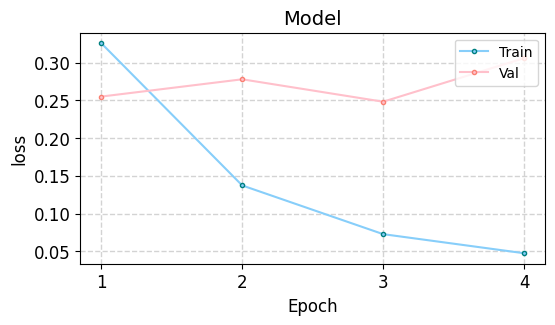

In [ ]:
# Plot Cross-Entropy Loss curve
draw_pics(record, 'loss', img_save=False, show=True)

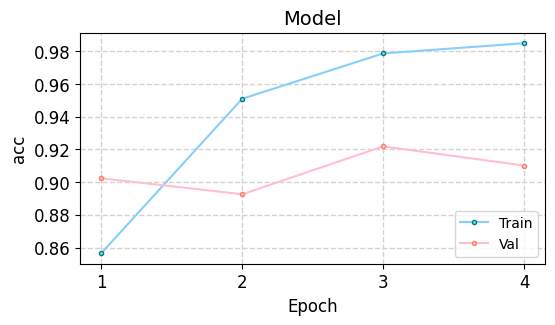

In [ ]:
# Plot Accuracy curve
draw_pics(record, 'acc', img_save=False, show=True)

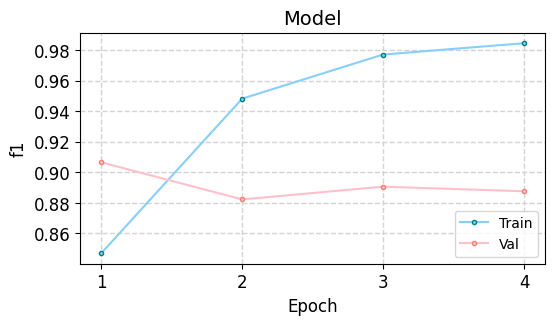

In [ ]:
# Plot F1-Score curve
draw_pics(record, 'f1', img_save=False, show=True)

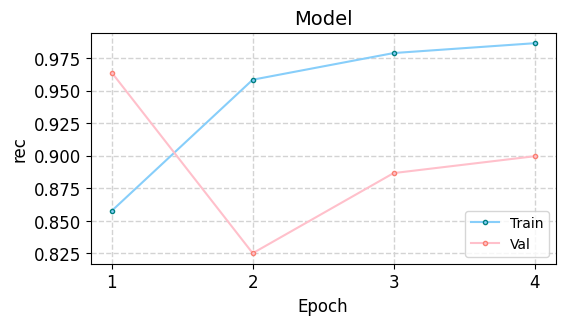

In [ ]:
# Plot Recall curve (Sensitivity)
draw_pics(record, 'rec', img_save=False, show=True)

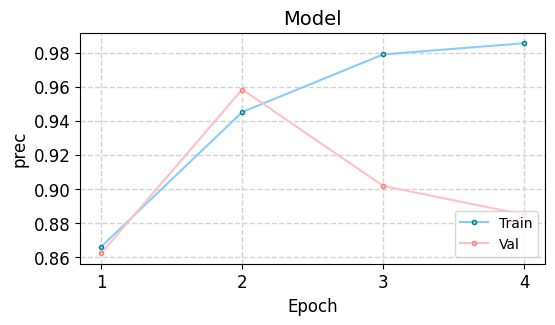

In [ ]:
# Plot Precision curve (Positive Predictive Value)
draw_pics(record, 'prec', img_save=False, show=True)

## **14. Inference Pipeline**

### **Probability Calculation & Label Mapping**
Defining utility functions to convert raw model logits into probabilities using **Softmax**, and mapping numerical indices back to readable class labels (Positive/Negative).



In [ ]:
def Softmax(x):
  """Computes the softmax of vector x."""
  return torch.exp(x) / torch.exp(x).sum()

def label2class(label):
  """Maps an integer label to its corresponding class name."""
  l2c = {0:'negative', 1:'positive'}
  return l2c[label]

### **15. Single Instance Prediction**
The `predict_one` function encapsulates the end-to-end inference lifecycle for a single text query:
1.  **Tokenization:** Converts raw text into BERT-compatible tensors (Input IDs, Masks).
2.  **Forward Pass:** Computes logits using the trained model in evaluation mode.
3.  **Post-processing:** Applies Softmax to interpret logits as probabilities and extracts the predicted class.

In [ ]:
def predict_one(query, model):
    """
    Predicts the sentiment of a single input sentence.

    Args:
        query (str): The input text to classify.
        model (nn.Module): The fine-tuned BERT classifier.

    Returns:
        tuple: (probabilities, predicted_class_name)
    """
    # Switch model to evaluation mode
    model.eval()

    # Initialize tokenizer from the pretrained configuration
    tokenizer = BertTokenizer.from_pretrained(parameters['config'])

    # 1. Tokenize the input text with padding and truncation
    inputs = tokenizer(
        query,
        padding='max_length',
        truncation=True,
        max_length=parameters['max_len'],
        return_tensors="pt"
    )

    # 2. Move input tensors to the computation device (GPU/CPU)
    input_ids = inputs['input_ids'].to(model.device)
    attention_mask = inputs['attention_mask'].to(model.device)
    token_type_ids = inputs['token_type_ids'].to(model.device)

    # 3. Perform inference (Forward pass) without gradient calculation
    with torch.no_grad():
        logits = model(input_ids=input_ids,
                       attention_mask=attention_mask,
                       token_type_ids=token_type_ids)

    # 4. Apply Softmax to get class probabilities
    # logits[0] selects the first (and only) sample in the batch
    probs = Softmax(logits[0]).cpu().numpy()  # logits[0] 是 batch 中第 0 個（因為只有一個輸入）

    # 5. Determine the predicted class index (Argmax) and map to label
    pred_label = int(torch.argmax(logits, dim=1).cpu().numpy()[0])
    pred = label2class(pred_label)

    return probs, pred

### **16. Model Deployment & Sanity Check**
Reloading the best-performing model weights from the saved checkpoint (`bert.pt`) to ensure the inference environment is independent of the training loop.

In [ ]:
from transformers import BertTokenizer

# 1. Initialize device and model architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
init_model = BertClassifier.from_pretrained(parameters['config'], parameters) # Initialize architecture

# 2. Load fine-tuned weights from the checkpoint file
model = load_checkpoint('./bert.pt', init_model, device).to(device)

Model loaded from <== ./bert.pt


In [ ]:
%%time
# Run a sanity check on a single example to verify inference latency
probs, pred = predict_one("This movie doesn't attract me", model)
print(pred)

negative
CPU times: user 100 ms, sys: 4 ms, total: 104 ms
Wall time: 313 ms


### **17. Batch Inference Strategy**
Defining a `predict` function designed to handle large-scale data via `DataLoader`. This allows for efficient batch processing of the entire test set without memory overflow.

In [ ]:
def predict(data_loader, model):
  """
    Performs batch inference on a dataset using a DataLoader.

    Args:
        data_loader (DataLoader): The iterable data loader containing test samples.
        model (nn.Module): The fine-tuned BERT classifier.

    Returns:
        tuple: (list of probabilities, list of predicted labels)
  """
  tokenizer = AutoTokenizer.from_pretrained(parameters['config'])
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  total_probs, total_pred = [], []

  # Switch model to evaluation mode
  model.eval()

  with torch.no_grad():
    for data in data_loader:
      # Move batch data to the computation device
      input_ids, attention_mask, \
      token_type_ids = [t.to(device) for t in data]

      # Forward pass: Compute logits
      logits = model(input_ids, attention_mask, token_type_ids)

      # Apply Softmax to get class probabilities
      probs = Softmax(logits)

      # Determine predicted class index (0 or 1)
      label_index = torch.argmax(probs[0], dim=0)
      pred = label_index.item()

      total_probs.append(probs)
      total_pred.append(pred)

  return total_probs, total_pred

### **18. Execution & Submission Generation**
Loading the test dataset, executing batch inference, and aggregating results. The final predictions are saved to `result.tsv` for submission or further analysis.

In [ ]:
# 1. Load and sample testing data
# Subsampling 500 instances for demonstration
test_df = pd.read_csv('./test.tsv', sep = '\t').sample(500).reset_index(drop=True)
test_dataset = CustomDataset('test', test_df, 'text', parameters)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 2. Execute Prediction
total_probs, total_pred = predict(test_loader, model)

# 3. Aggregate Results
res = test_df.copy()
res['pred'] = total_pred # Append predictions to the dataframe

# 4. Save results to disk
res.to_csv('./result.tsv', sep='\t', index=False)

In [ ]:
res.head(5)

,text,label,pred
0,"This moody, creepy horror flick begins on a ca...",1,1
1,The movie was watchable while Nicolson was on ...,0,0
2,I saw this film yesterday on TV. I had just fi...,0,0
3,This movie deserves credit for its original ap...,0,0
4,"OK, yes I know I'm a Philistine, and I have no...",0,0


In [ ]:
# Calculate accuracy on the test set
correct = 0
for idx, pred in enumerate(res['pred']):
  if pred == res['label'][idx]:
    correct += 1
print('test accuracy = %.4f'%(correct/len(test_df)))

test accuracy = 0.9540
